# EDA 및 모델 돌리기

In [24]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.preprocessing import MinMaxScaler
#standardscaler
from sklearn.preprocessing import StandardScaler
#robustscaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import StratifiedKFold

In [56]:
#샘플 데이터 불러오기
house_train = pd.read_csv("./../../Datas/train_restore.csv")
house_test = pd.read_csv("./../../Datas/test_restore.csv")

In [75]:
#data concat
house_train['is_test'] = 0
house_test['is_test'] = 1
concat = pd.concat([house_train, house_test])

# 살릴 column들 정리
use_cols = np.array(['전용면적(㎡)', '계약년월', '층','거래유형', 'k-전체동수',
'k-전체세대수', 'k-연면적', '주차대수', '좌표X', '좌표Y', 'target', 
'시군구', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식',
'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-홈페이지', 'k-전화번호', 'k-팩스번호',
'경비비관리형태', '세대전기계약방법', '청소비관리형태', 'is_test'
])

concat = concat[use_cols]
df = concat.copy()

df['구'] = df['시군구'].str.split(' ').str[1]
df['동'] = df['시군구'].str.split(' ').str[1] + ' ' + df['시군구'].str.split(' ').str[2]
df_train = df[df['is_test'] == 0]
df_test = df[df['is_test'] == 1]
df_train.drop(columns=['is_test'], inplace=True)
df_test.drop(columns=['is_test', 'target'], inplace=True)


In [76]:
# # 계약년월 count로 매핑
# df_dates = df_train['계약년월'].unique().tolist() + df_test['계약년월'].unique().tolist()

# #df_dates 중 중복된 값 제거
# df_dates = list(set(df_dates))
# #df_dates 정렬
# df_dates.sort()

# date_map = dict(zip(df_dates, range(1,len(df_dates)+1)))

# df_train['계약년월'] = df_train['계약년월'].map(date_map)
# df_test['계약년월'] = df_test['계약년월'].map(date_map)




### 시계열 분석

In [5]:
def str_to_datetime(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # 문자열에서 특수문자 제거('-')
    df[col] = df[col].astype(str).str.replace('-', '')
    # 문자열을 datetime으로 변환
    df[col] = pd.to_datetime(df[col], format='%Y%m')
    df[col] = df[col].dt.strftime('%Y-%m')
    return df

#### 기간당 global 집값 평균으로 encoding

In [9]:
df_train = str_to_datetime(df_train, '계약년월')
df_test = str_to_datetime(df_test, '계약년월')

df_time_check = df_train.groupby('계약년월')['target'].mean().reset_index()
df_time_check.sort_values(by='계약년월', inplace=True)
df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월']).dt.strftime('%Y-%m')
display(df_time_check)

,계약년월,target
0,2007-01,27907.070115
1,2007-02,28687.696452
2,2007-03,26188.014682
3,2007-04,29135.020486
4,2007-05,32721.145273
...,...,...
193,2023-02,98699.860181
194,2023-03,101508.679474
195,2023-04,105340.274426
196,2023-05,108825.542857


##### 추세선 적용(2017년 이전, 2017년 이후)

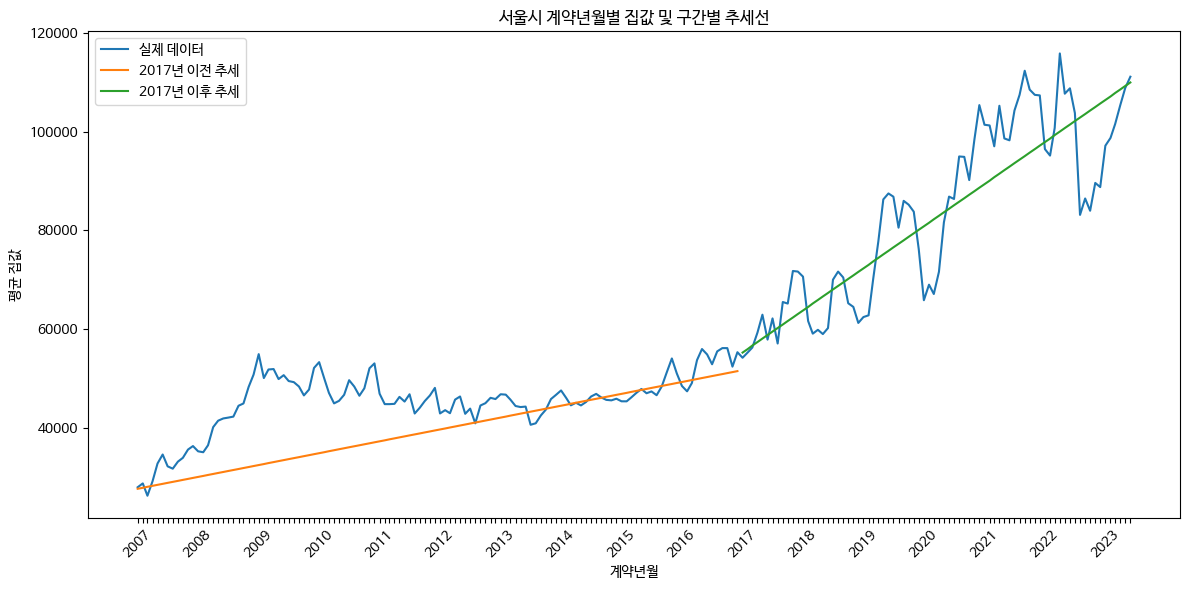

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 계약년월을 datetime으로 변환
df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월'])
df_time_check = df_time_check.sort_values('계약년월').reset_index(drop=True)
df_time_check['연도'] = df_time_check['계약년월'].dt.year

plt.figure(figsize=(12, 6))
plt.plot(df_time_check['계약년월'], df_time_check['target'], label='실제 데이터')

# 2017년 이전과 이후로 데이터 나누기
df_before_2017 = df_time_check[df_time_check['연도'] < 2017]
df_after_2017 = df_time_check[df_time_check['연도'] >= 2017]

# 함수: 추세선 그리기
def plot_trend(df, label):
    if len(df) < 2:
        return
    n = len(df)
    y_start = df['target'].values[:3].mean()
    x = np.arange(n).reshape(-1, 1)
    y = df['target'].values.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    y_end = model.predict([[n - 1]])[0][0]
    y_trend = np.linspace(y_start, y_end, n)
    plt.plot(df['계약년월'], y_trend, label=label)

# 추세선 그리기
plot_trend(df_before_2017, '2017년 이전 추세')
plot_trend(df_after_2017, '2017년 이후 추세')

# x축 라벨 설정
xticks = df_time_check['계약년월']
xtick_labels = [d.strftime('%Y') if d.month == 1 else '' for d in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)

plt.title('서울시 계약년월별 집값 및 구간별 추세선')
plt.xlabel('계약년월')
plt.ylabel('평균 집값')
plt.legend()
plt.tight_layout()
plt.show()


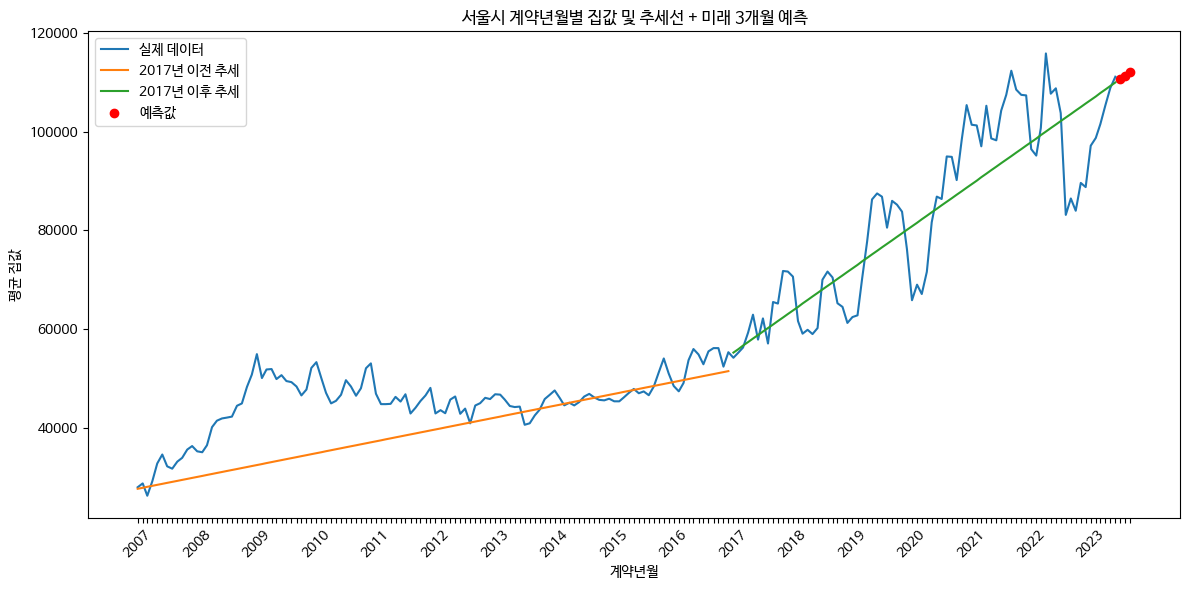

== 인코딩 맵 샘플 ==
2022-12: 105678.21
2023-01: 106389.20
2023-02: 107100.20
2023-03: 107811.19
2023-04: 108522.19
2023-05: 109233.18
2023-06: 109944.17
2023-07: 110635.27
2023-08: 111326.37
2023-09: 112017.47


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 계약년월을 datetime으로 변환
df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월'])
df_time_check = df_time_check.sort_values('계약년월').reset_index(drop=True)
df_time_check['연도'] = df_time_check['계약년월'].dt.year

# 2017년 기준으로 데이터 나누기
df_before_2017 = df_time_check[df_time_check['연도'] < 2017].copy()
df_after_2017 = df_time_check[df_time_check['연도'] >= 2017].copy()

# 인코딩 맵 저장용 dict
encoding_map = {}

plt.figure(figsize=(12, 6))
plt.plot(df_time_check['계약년월'], df_time_check['target'], label='실제 데이터')

# 추세선 그리기 및 인코딩 값 생성 함수
def plot_trend_and_encode(df, label):
    if len(df) < 2:
        return None
    n = len(df)
    y_start = df['target'].values[:3].mean()
    x = np.arange(n).reshape(-1, 1)
    y = df['target'].values.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    y_end = model.predict([[n - 1]])[0][0]
    y_trend = np.linspace(y_start, y_end, n)

    # 시각화용 추세선
    plt.plot(df['계약년월'], y_trend, label=label)

    # 인코딩 맵에 저장
    for i, dt in enumerate(df['계약년월']):
        ym_str = dt.strftime('%Y-%m')
        encoding_map[ym_str] = y_trend[i]

    return model, y_start, n

# 각 구간별 추세선 및 인코딩
model_before, _, _ = plot_trend_and_encode(df_before_2017, '2017년 이전 추세')
model_after, y_start_after, n_after = plot_trend_and_encode(df_after_2017, '2017년 이후 추세')

# === 3개월 미래 예측 ===
future_months = 3
last_date = df_after_2017['계약년월'].max()

for i in range(1, future_months + 1):
    future_date = last_date + pd.DateOffset(months=i)
    x_future = np.array([[n_after - 1 + i]])
    y_future = model_after.predict(x_future)[0][0]
    encoding_map[future_date.strftime('%Y-%m')] = y_future

    # 시각화용 점 찍기
    plt.scatter(future_date, y_future, color='red', label='예측값' if i == 1 else "")

# x축 라벨 설정
xticks = pd.date_range(start=df_time_check['계약년월'].min(),
                       end=last_date + pd.DateOffset(months=future_months), freq='MS')
xtick_labels = [d.strftime('%Y') if d.month == 1 else '' for d in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)

plt.title('서울시 계약년월별 집값 및 추세선 + 미래 3개월 예측')
plt.xlabel('계약년월')
plt.ylabel('평균 집값')
plt.legend()
plt.tight_layout()
plt.show()

# 결과 확인용 출력 (일부만 출력)
print("== 인코딩 맵 샘플 ==")
for k in sorted(encoding_map.keys())[-10:]:  # 최근 10개 출력
    print(f"{k}: {encoding_map[k]:.2f}")

df_train['계약년월'] = df_train['계약년월'].map(encoding_map)
df_test['계약년월'] = df_test['계약년월'].map(encoding_map)


##### 추체선 적용(1년단위)

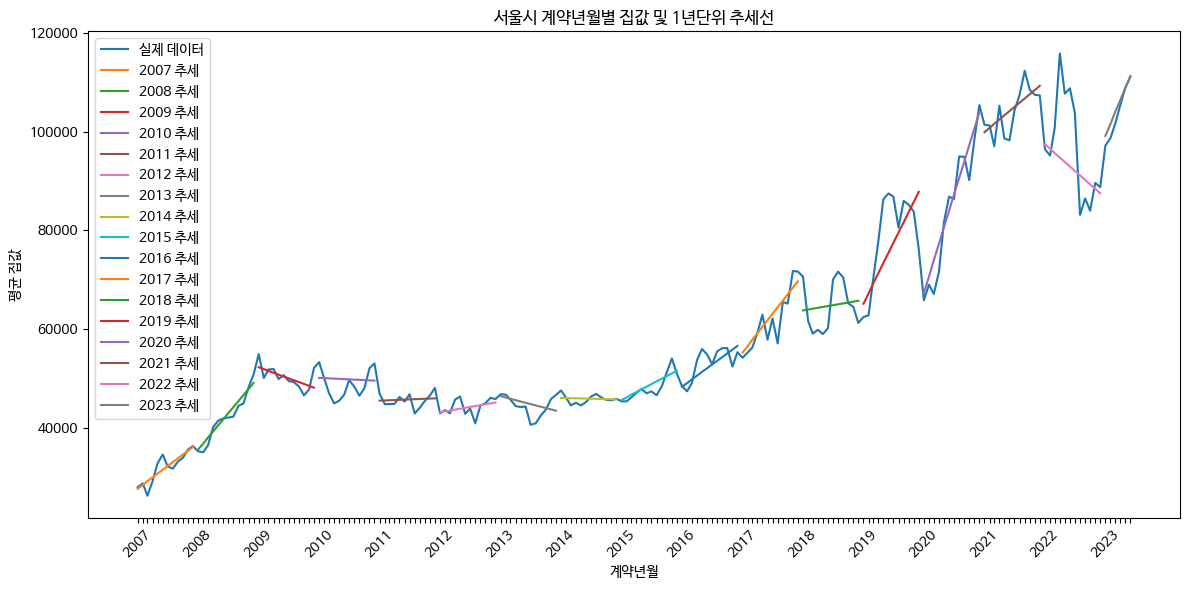

In [88]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # 계약년월을 datetime으로 변환
# df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월'])
# df_time_check = df_time_check.sort_values('계약년월').reset_index(drop=True)
# df_time_check['연도'] = df_time_check['계약년월'].dt.year

# plt.figure(figsize=(12, 6))
# plt.plot(df_time_check['계약년월'], df_time_check['target'], label='실제 데이터')

# # 이전 연도의 추세선 끝점 저장용
# prev_y_end = None

# for year in sorted(df_time_check['연도'].unique()):
#     df_year = df_time_check[df_time_check['연도'] == year]
#     if len(df_year) < 2:
#         continue

#     n = len(df_year)

#     # 시작 y값: 0~2까지의 평균
#     y_start = df_year['target'].values[:3].mean()

#     # 선형 회귀로 해당 연도 종점 예측
#     x = np.arange(n).reshape(-1, 1)
#     y = df_year['target'].values.reshape(-1, 1)
#     model = LinearRegression().fit(x, y)
#     y_end = model.predict([[n - 1]])[0][0]  # 종점 예측값

#     # 추세선 생성
#     y_trend = np.linspace(y_start, y_end, n)
#     prev_y_end = y_trend[-1]

#     plt.plot(df_year['계약년월'], y_trend, label=f'{year} 추세')

# # x축 라벨 설정
# xticks = df_time_check['계약년월']
# xtick_labels = [d.strftime('%Y') if d.month == 1 else '' for d in xticks]
# plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)

# plt.title('서울시 계약년월별 집값 및 1년단위 추세선')
# plt.xlabel('계약년월')
# plt.ylabel('평균 집값')
# plt.legend()
# plt.tight_layout()
# plt.show()


##### 추세선 적용(6개월 단위)

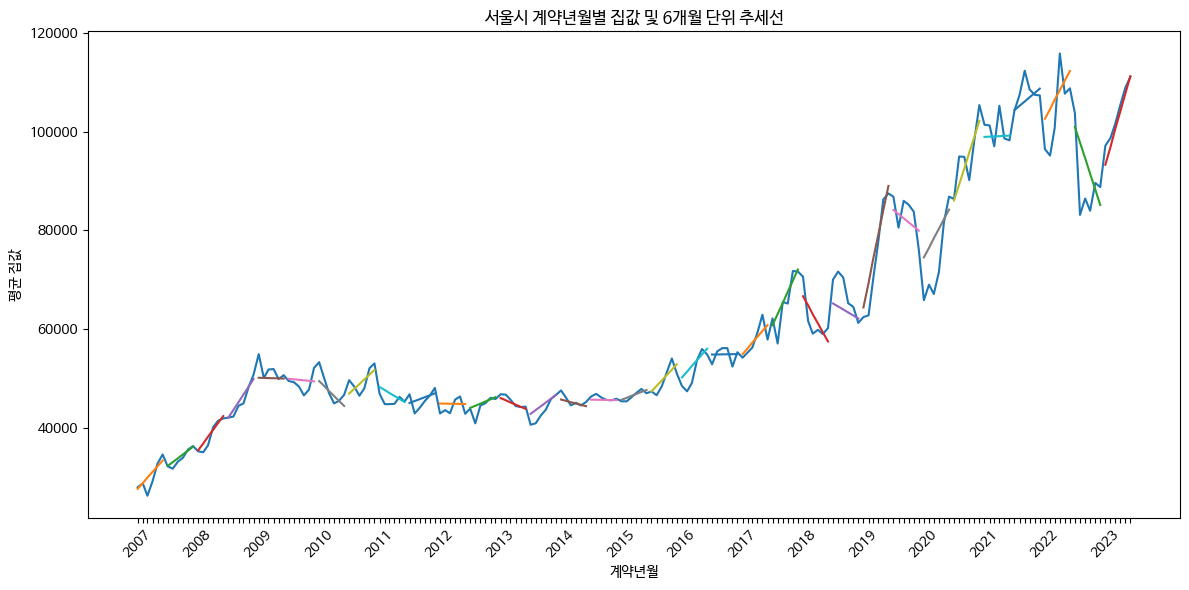

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 계약년월을 datetime으로 변환
df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월'])
df_time_check = df_time_check.sort_values('계약년월').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(df_time_check['계약년월'], df_time_check['target'], label='실제 데이터')

# 6개월 단위로 나누기
total_months = len(df_time_check)
window_size = 6
i = 0

while i + window_size <= total_months:
    df_segment = df_time_check.iloc[i:i + window_size].copy()
    dates = df_segment['계약년월']
    targets = df_segment['target'].values

    if i > 3:
        df_segment_behind = df_time_check.iloc[i-3:i].copy()
        targets_behind = df_segment_behind['target'].values
        y_start = (targets_behind.mean() + targets[:3].mean()) / 2
    else:
        y_start = targets[:3].mean() if len(targets) >= 3 else targets[0]

    # 종점: 선형 회귀로 예측
    x = np.arange(len(df_segment)).reshape(-1, 1)
    y = targets.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    y_end = model.predict([[len(df_segment) - 1]])[0][0]

    # 추세선 생성
    y_trend = np.linspace(y_start, y_end, len(df_segment))

    # 추세선 플롯
    plt.plot(dates, y_trend, label=f"{dates.iloc[0].strftime('%Y-%m')} ~ {dates.iloc[-1].strftime('%Y-%m')} 추세")

    i += window_size  # 다음 6개월로 이동

# x축 라벨 설정
xticks = df_time_check['계약년월']
xtick_labels = [d.strftime('%Y') if d.month == 1 else '' for d in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)

plt.title('서울시 계약년월별 집값 및 6개월 단위 추세선')
plt.xlabel('계약년월')
plt.ylabel('평균 집값')
plt.tight_layout()
plt.show()


In [ ]:
# def contract_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
#   df_train_copy = df_train.copy()
#   df_test_copy = df_test.copy()

#   df_train_copy['계약년월'] = pd.to_datetime(df_train_copy['계약년월'])
#   df_test_copy['계약년월'] = pd.to_datetime(df_test_copy['계약년월'])

#   df_train_copy['계약년월'] = df_train_copy['계약년월'].dt.strftime('%Y%m')
#   df_test_copy['계약년월'] = df_test_copy['계약년월'].dt.strftime('%Y%m')

In [ ]:
# from dateutil.relativedelta import relativedelta


# # 계약년월 datetime 변환
# df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월'])
# df_time_check = df_time_check.sort_values('계약년월').reset_index(drop=True)

# # 저장할 추세선 예측값 딕셔너리
# trend_dict = {}

# # 6개월 단위 구간 처리
# window_size = 6
# total_months = len(df_time_check)
# i = 0

# while i + window_size <= total_months:
#     df_segment = df_time_check.iloc[i:i + window_size].copy()
#     dates = df_segment['계약년월']
#     targets = df_segment['target'].values
    
#     if i > 3:
#         df_segment_behind = df_time_check.iloc[i-3:i].copy()
#         targets_behind = df_segment_behind['target'].values
#         y_start = (targets_behind.mean() + targets[:3].mean()) / 2
#     else:
#         y_start = targets[:3].mean() if len(targets) >= 3 else targets[0]

#     # 선형 회귀로 종점 예측
#     x = np.arange(len(targets)).reshape(-1, 1)
#     y = targets.reshape(-1, 1)
#     model = LinearRegression().fit(x, y)
#     y_end = model.predict([[len(targets) - 1]])[0][0]

#     # 추세선 생성
#     y_trend = np.linspace(y_start, y_end, len(targets))

#     # trend_dict에 저장
#     for j, date in enumerate(dates):
#         key = date.strftime('%Y-%m')
#         trend_dict[key] = round(float(y_trend[j]), 2)

#     i += window_size

# # 🔮 미래 6개월 예측
# # 마지막 날짜 기준으로 이어서 생성
# last_date = df_time_check['계약년월'].iloc[-1]
# last_6 = df_time_check.iloc[-window_size:].copy()
# x = np.arange(len(last_6)).reshape(-1, 1)
# y = last_6['target'].values.reshape(-1, 1)

# model = LinearRegression().fit(x, y)
# y_end_future = model.predict([[len(last_6) - 1]])[0][0]
# y_start_future = y[3:].mean()

# # 미래 6개월 추세선 생성
# y_future = np.linspace(y_start_future, y_end_future, window_size)

# for k in range(window_size):
#     future_date = last_date + relativedelta(months=k + 1)
#     key = future_date.strftime('%Y-%m')
#     trend_dict[key] = round(float(y_future[k]), 2)

# # ✅ 결과 확인
# for k in sorted(trend_dict.keys()):
#     print(f"{k}: {trend_dict[k]}")


2007-01: 27594.26
2007-02: 28737.04
2007-03: 29879.82
2007-04: 31022.61
2007-05: 32165.39
2007-06: 33308.17
2007-07: 32218.23
2007-08: 32997.68
2007-09: 33777.14
2007-10: 34556.59
2007-11: 35336.04
2007-12: 36115.5
2008-01: 35379.59
2008-02: 36770.92
2008-03: 38162.26
2008-04: 39553.59
2008-05: 40944.93
2008-06: 42336.26
2008-07: 42000.42
2008-08: 43570.33
2008-09: 45140.23
2008-10: 46710.14
2008-11: 48280.04
2008-12: 49849.95
2009-01: 50091.59
2009-02: 50061.48
2009-03: 50031.37
2009-04: 50001.26
2009-05: 49971.15
2009-06: 49941.04
2009-07: 49879.81
2009-08: 49779.52
2009-09: 49679.23
2009-10: 49578.94
2009-11: 49478.65
2009-12: 49378.36
2010-01: 49424.76
2010-02: 48416.54
2010-03: 47408.31
2010-04: 46400.09
2010-05: 45391.87
2010-06: 44383.65
2010-07: 46890.7
2010-08: 47848.7
2010-09: 48806.7
2010-10: 49764.69
2010-11: 50722.69
2010-12: 51680.69
2011-01: 48228.25
2011-02: 47621.43
2011-03: 47014.61
2011-04: 46407.79
2011-05: 45800.98
2011-06: 45194.16
2011-07: 44988.73
2011-08: 45378

In [104]:
# 계약년월 mapping
df_train = str_to_datetime(df_train, '계약년월')
df_train['계약년월'] = df_train['계약년월'].map(trend_dict)
df_test = str_to_datetime(df_test, '계약년월')
df_test['계약년월'] = df_test['계약년월'].map(trend_dict)


0          72035.10
1          72035.10
2          72035.10
3          66618.52
4          66618.52
             ...   
1118817    32218.23
1118818    32997.68
1118819    32997.68
1118820    33777.14
1118821    27594.26
Name: 계약년월, Length: 1118822, dtype: float64

#### 기간당 구별 평균 집값으로 encoding

In [237]:
def contract_gu_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
  df_train_copy = df_train.copy()
  df_test_copy = df_test.copy()

  df_test_copy['계약년월']

  df_time_check = df_train_copy.groupby(['구','계약년월'])['target'].mean().reset_index()
  df_time_check.sort_values(by=['구','계약년월'], inplace=True) 
  df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월'].astype(str), format="%Y%m")
  
  #예측할 데이터의 가장 최근 날짜
  target_future_date = pd.to_datetime(df_test_copy['계약년월'].max().astype(str), format="%Y%m")
  
  gu_stack = []

  gus = df_time_check['구'].unique()

  for gu in gus:
    df_gu = df_time_check[df_time_check['구'] == gu]
    recent_date = df_gu['계약년월'].iloc[-1]
    forward_month = (target_future_date.year - recent_date.year) * 12 + (target_future_date.month - recent_date.month)

    #가장 최근 6개월 데이터를 통해서 다음 개월 예측
    df_gu_recent = df_gu.iloc[-6:]
    x = np.arange(len(df_gu_recent)).reshape(-1, 1)
    y = df_gu_recent['target'].values.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    y_future = model.predict(np.arange(x[-1] + 1, x[-1] + 1 + forward_month).reshape(-1, 1))[:,0]

    new_gu = pd.DataFrame({'계약년월': pd.date_range(start=recent_date, periods=forward_month, freq='M'), 'target': y_future})
    new_gu['구'] = gu
    new_gu['계약년월'] = new_gu['계약년월'] + pd.Timedelta(days=1)
    df_gu = pd.concat([df_gu, new_gu])
    gu_stack.append(df_gu)
  
    
  df_gu_encoding = pd.concat(gu_stack)
  df_gu_encoding['계약년월'] = df_gu_encoding['계약년월'].dt.strftime('%Y-%m')
  df_gu_encoding = df_gu_encoding.rename(columns={'target':'계약년월(구)_target'})
  
  df_train_copy = str_to_datetime(df_train_copy, '계약년월')
  df_test_copy = str_to_datetime(df_test_copy, '계약년월')
  df_train_encode = df_train_copy.merge(df_gu_encoding, on=['계약년월', '구'], how='left')
  df_test_encode = df_test_copy.merge(df_gu_encoding, on=['계약년월', '구'], how='left')
  df_train_encode.drop(columns=['계약년월'], inplace=True)
  df_test_encode.drop(columns=['계약년월'], inplace=True)
  return df_train_encode, df_test_encode
  

### Arima 모델

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  198
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1907.016
Date:                Mon, 12 May 2025   AIC                           3820.031
Time:                        05:44:24   BIC                           3829.865
Sample:                             0   HQIC                          3824.012
                                - 198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1247      0.052      2.386      0.017       0.022       0.227
ma.L1         -0.9999      0.062    -16.074      0.000      -1.122      -0.878
sigma2      1.614e+07   3.86e-09   4.18e+15      0.0

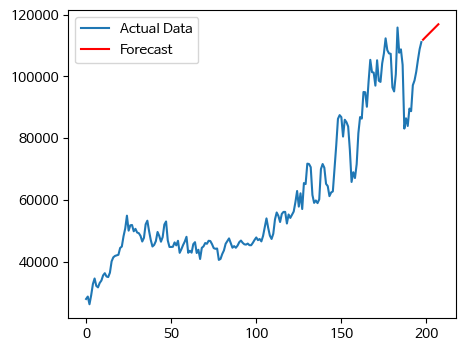

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 예시 데이터 (여기서는 랜덤 데이터로 대체)
np.random.seed(0)
data = np.random.randn(100)

# 데이터를 pandas Series로 변환
time_series = df_time_check['target']

df_diff = df_time_check['target'].diff().dropna()
df_diff2 = df_diff.diff().dropna()


# # ACF(Autocorrelation)와 PACF(Partial Autocorrelation) 플롯
# plot_acf(df_diff2)
# plot_pacf(df_diff2)
# plt.show()

# ARIMA 모델 설정 (p=1, d=1, q=1)
model = ARIMA(time_series, order=(1, 2, 1))

# 모델 학습
model_fit = model.fit()

# 모델 요약 출력
print(model_fit.summary())

# 예측
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# 예측 결과 시각화
plt.figure(figsize=(5, 4))
plt.plot(time_series, label="Actual Data")
plt.plot(np.arange(len(time_series), len(time_series) + forecast_steps), forecast, label="Forecast", color='red')
plt.legend()
plt.show()


In [125]:
def my_auto_arima(data, order,sort = 'AIC'):
 order_list = []
 aic_list = []
 bic_lsit = []
 for p in range(order[0]):
  for d in range(order[1]):
    for q in range(order[2]):
      model = ARIMA(data, order=(p,d,q))
      try:
        model_fit = model.fit()
        c_order = f'p{p} d{d} q{q}'
        aic = model_fit.aic
        bic = model_fit.bic
        order_list.append(c_order)
        aic_list.append(aic)
        bic_list.append(bic)
      except:
        pass
 result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
 result_df.sort_values(sort, inplace=True)
 return result_df

In [126]:
my_auto_arima(df_time_check['target'],[3,3,3])

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,AIC
16,p1 d2 q1,3820.031049
8,p0 d2 q2,3820.112194
7,p0 d2 q1,3821.332089
3,p0 d1 q0,3821.372951
12,p1 d1 q0,3822.819445
4,p0 d1 q1,3822.855392
17,p1 d2 q2,3823.879688
26,p2 d2 q2,3824.024443
23,p2 d1 q2,3824.029871
5,p0 d1 q2,3824.660252


In [122]:
from statsmodels.tsa.stattools import adfuller
# 1차 차분이 유의미한지 확인
y = df_time_check['target']
y_1diff = df_time_check.diff().dropna()['target']
result = adfuller(y)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -0.101
원 데이터 p-value: 0.949
1차 차분 ADF Statistic: -5.878
1차 차분 p-value: 0.000


### StratifiedKFold 실험

In [76]:
# 계약년월 formatting
def str_to_datetime(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # 문자열에서 특수문자 제거('-')
    df[col] = df[col].astype(str).str.replace('-', '')
    # 문자열을 datetime으로 변환
    df[col] = pd.to_datetime(df[col], format='%Y%m')
    df[col] = df[col].dt.strftime('%Y-%m')
    return df

In [77]:
# target encoding 함수
def target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str, encode_col: str, 
                   alpha: float = 0.5, global_mean: float = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()
    
    # 전체 평균 계산
    if global_mean is None:
        global_mean = df_train[target_col].mean()
    
    # 카테고리별 통계 계산
    category_stats = df_train.groupby(encode_col).agg({
        target_col: ['count', 'mean']
    }).reset_index()
    
    category_stats.columns = [encode_col, 'count', 'mean']
    
    # # 스무딩 적용
    # category_stats['smoothed_mean'] = (
    #     (category_stats['count'] * category_stats['mean'] + alpha * global_mean) / 
    #     (category_stats['count'] + alpha)
    # )
    
    # 인코딩 적용
    encoding_map = dict(zip(category_stats[encode_col], category_stats['mean']))
    
    # 학습 데이터에 적용
    df_encoded_train[f'{encode_col}_target'] = df_encoded_train[encode_col].map(encoding_map)
    
    # 테스트 데이터에 적용 (학습 데이터에 없는 카테고리는 전체 평균 사용)
    df_encoded_test[f'{encode_col}_target'] = df_encoded_test[encode_col].map(encoding_map)
    df_encoded_test[f'{encode_col}_target'].fillna(global_mean, inplace=True)
    
    return df_encoded_train, df_encoded_test
    

In [78]:
# 동 target encoding 함수
def dong_target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()
    df_gu_dong = df_encoded_train.groupby(['구', '동'])[target_col].mean().reset_index()
    df_gu = df_encoded_train.groupby('구')[target_col].mean().reset_index()
    df_gu.columns = ['구', '구_target']
    df_gu_dong = df_gu_dong.merge(df_gu, on='구', how='left')
    df_gu_dong['동_target'] = df_gu_dong[target_col] / df_gu_dong['구_target']
    

    encoding_map = dict(zip(df_gu_dong['동'], df_gu_dong['동_target']))

    df_encoded_train['동_target'] = df_encoded_train['동'].map(encoding_map)
    df_encoded_test['동_target'] = df_encoded_test['동'].map(encoding_map)

    # 테스트 데이터 결측치 채울 때 구 평균 사용
    df_encoded_test['동_target'].fillna(1, inplace=True)

    return df_encoded_train, df_encoded_test

In [79]:
# 아파트명 target encoding 함수
def apartment_target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str, alpha: float = 0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()

    # 아파트명 면적당가격
    df_cost_area = df_encoded_train.groupby(['아파트명', '구', '동'])[['전용면적(㎡)', target_col]].agg(['count', 'mean']).reset_index()
    df_cost_area.columns = ['아파트명', '구', '동', '_', 'area_mean', 'count', 'target_mean']
    df_cost_area['면적당가격'] = df_cost_area['target_mean'] / df_cost_area['area_mean']

    # 구 면적당가격
    df_gu = df_encoded_train.groupby('구')[['전용면적(㎡)', target_col]].mean().reset_index()
    df_gu['면적당가격'] = df_gu[target_col] / df_gu['전용면적(㎡)']

    # 구 면적당가격 매핑
    gu_encoding_map = dict(zip(df_gu['구'], df_gu['면적당가격']))
    df_cost_area['구_면적당가격'] = df_cost_area['구'].map(gu_encoding_map)

    df_cost_area['면적당가격_smoothed'] = (
        (df_cost_area['면적당가격'] * df_cost_area['count'] + alpha * df_cost_area['구_면적당가격']) / 
        (df_cost_area['count'] + alpha)
    )
    

    # 동 면적당가격 
    df_dong = df_encoded_train.groupby('동')[['전용면적(㎡)', target_col]].mean().reset_index()
    df_dong['면적당가격'] = df_dong[target_col] / df_dong['전용면적(㎡)']
    
    # 동 면적당가격 매핑
    dong_encoding_map = dict(zip(df_dong['동'], df_dong['면적당가격']))
    df_cost_area['동_면적당가격'] = df_cost_area['동'].map(dong_encoding_map)

    # 테스트 데이터 결측치 채울 때 동 면적당가격 혹은 구 면적당가격으로 채우기
    df_encoded_test['동_면적당가격'] = df_encoded_test['동'].map(dong_encoding_map)
    df_encoded_test['구_면적당가격'] = df_encoded_test['구'].map(gu_encoding_map)

    # 아파트명 면적당가격 매핑
    df_encoding_map = dict(zip(df_cost_area['아파트명'], df_cost_area['면적당가격_smoothed']))
    df_encoded_train['아파트명_면적당가격'] = df_encoded_train['아파트명'].map(df_encoding_map)
    df_encoded_test['아파트명_면적당가격'] = df_encoded_test['아파트명'].map(df_encoding_map)
    df_encoded_test['아파트명_면적당가격'].fillna(df_encoded_test['동_면적당가격'], inplace=True)
    df_encoded_test['아파트명_면적당가격'].fillna(df_encoded_test['구_면적당가격'], inplace=True)
    df_encoded_test.drop(columns=['동_면적당가격', '구_면적당가격'], inplace=True)

    df_encoded_train.drop(columns=['아파트명', '구', '동', '시군구'], inplace=True)
    df_encoded_test.drop(columns=['아파트명', '구', '동', '시군구'], inplace=True)
    return df_encoded_train, df_encoded_test


In [80]:
# 라벨 인코딩 함수
def label_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    dt_train = df_train.copy()
    dt_test = df_test.copy()
    categorical_features = dt_train.select_dtypes(include=[np.object]).columns

    # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
    label_encoders = {}

    # Implement Label Encoding
    for col in tqdm( categorical_features ):
        # 모든 고유값 수집 (학습 + 테스트)

        # 모든 고유값 수집 (학습 + 테스트)
        all_unique_values = pd.concat([dt_train[col], dt_test[col]]).unique()
        
        # 레이블 인코더 생성 및 학습
        lbl = LabelEncoder()
        lbl.fit(all_unique_values.astype(str))  # 문자열로 변환
        
        # 변환
        dt_train[col] = lbl.transform(dt_train[col].astype(str))
        dt_test[col] = lbl.transform(dt_test[col].astype(str))
        
        label_encoders[col] = lbl
    return dt_train, dt_test, label_encoders

In [81]:
# 적은 데이터를 중복 샘플링하는 함수(K-fold 실험을 위해)
from collections import Counter

def replicate_rare_samples(df, col, n_splits):
    counts = df[col].value_counts()
    dfs = [df]
    for val, cnt in counts.items():
        if cnt < n_splits:
            need = n_splits - cnt
            extra = df[df[col] == val].sample(need, replace=True, random_state=42)
            dfs.append(extra)
    return pd.concat(dfs, ignore_index=True)

In [82]:
# 계약년월 2017년 전후 트렌드로 encoidng 하는 함수
from sklearn.linear_model import LinearRegression

def contract_encoding(df_train:pd.DataFrame, df_test:pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
  df_train_copy = df_train.copy()
  df_test_copy = df_test.copy()

  df_train_copy = str_to_datetime(df_train_copy, '계약년월')
  df_test_copy = str_to_datetime(df_test_copy, '계약년월')

  df_time_check = df_train_copy.groupby('계약년월')['target'].mean().reset_index()
  df_time_check.sort_values(by='계약년월', inplace=True)
  df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월']).dt.strftime('%Y-%m')
  
  # 계약년월을 datetime으로 변환
  df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월'])
  df_time_check = df_time_check.sort_values('계약년월').reset_index(drop=True)
  df_time_check['연도'] = df_time_check['계약년월'].dt.year

  # 2017년 기준으로 데이터 나누기
  df_before_2017 = df_time_check[df_time_check['연도'] < 2017].copy()
  df_after_2017 = df_time_check[df_time_check['연도'] >= 2017].copy()

  # 인코딩 맵 저장용 dict
  encoding_map = {}


  # 추세선 그리기 및 인코딩 값 생성 함수
  def trend_encode(df, label):
      if len(df) < 2:
          return None
      n = len(df)
      y_start = df['target'].values[:3].mean()
      x = np.arange(n).reshape(-1, 1)
      y = df['target'].values.reshape(-1, 1)
      model = LinearRegression().fit(x, y)
      y_end = model.predict([[n - 1]])[0][0]
      y_trend = np.linspace(y_start, y_end, n)

      # 인코딩 맵에 저장
      for i, dt in enumerate(df['계약년월']):
          ym_str = dt.strftime('%Y-%m')
          encoding_map[ym_str] = y_trend[i]

      return model, y_start, n

  # 각 구간별 추세선 및 인코딩
  model_before, _, _ = trend_encode(df_before_2017, '2017년 이전 추세')
  model_after, y_start_after, n_after = trend_encode(df_after_2017, '2017년 이후 추세')

  # === 3개월 미래 예측 ===
  future_months = 3
  last_date = df_after_2017['계약년월'].max()

  for i in range(1, future_months + 1):
      future_date = last_date + pd.DateOffset(months=i)
      x_future = np.array([[n_after - 1 + i]])
      y_future = model_after.predict(x_future)[0][0]
      encoding_map[future_date.strftime('%Y-%m')] = y_future

  df_train_copy['계약년월'] = df_train_copy['계약년월'].map(encoding_map)
  df_test_copy['계약년월'] = df_test_copy['계약년월'].map(encoding_map)

  return df_train_copy, df_test_copy


In [83]:
def areaPerone(df_train:pd.DataFrame, df_test:pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
  df_train_copy = df_train.copy()
  df_test_copy = df_test.copy()
  df_train_copy['areaPerOne'] = df_train_copy['k-연면적'] / df_train_copy['k-전체세대수'].replace(0, np.nan)
  df_test_copy['areaPerOne'] = df_test_copy['k-연면적'] / df_test_copy['k-전체세대수'].replace(0, np.nan)
  df_train_copy['areaPerOne'] = df_train_copy['areaPerOne'].fillna(df_train_copy['areaPerOne'].median())
  df_test_copy['areaPerOne'] = df_test_copy['areaPerOne'].fillna(df_test_copy['areaPerOne'].median())
  return df_train_copy, df_test_copy

In [84]:
k = 5

# 동 데이터 중 빈도수가 적은 데이터를 중복 샘플링(K-fold 실험을 위해)
df_train = replicate_rare_samples(df_train, '동', 2)

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)



rmse_scores = []
train_rmse_scores = []  # train RMSE를 저장할 리스트 추가
models = []


for fold, (train_index, valid_index) in enumerate(skf.split(df_train, df_train['동'])):
    print(f'Fold {fold+1} : {len(train_index)} / {len(valid_index)}')
    train_df = df_train.iloc[train_index]
    valid_df = df_train.iloc[valid_index]

    # 구 target encoding
    train_df, valid_df = target_encoding(train_df, valid_df, 'target', '구')
    # 동 target encoding
    train_df, valid_df = dong_target_encoding(train_df, valid_df, 'target')

    # 아파트명 target encoding
    train_df, valid_df = apartment_target_encoding(train_df, valid_df, 'target')

    # 계약년월 target encoding
    train_df, valid_df = contract_encoding(train_df, valid_df)

    # # 면적당가격 보간
    # train_df, valid_df = areaPerone(train_df, valid_df)

    numeric_features = train_df.select_dtypes(include=[np.number]).columns
    categorical_features = train_df.select_dtypes(include=[np.object]).columns

    # 범주형 변수에 대한 보간
    train_df[categorical_features] = train_df[categorical_features].fillna('NULL')
    valid_df[categorical_features] = valid_df[categorical_features].fillna('NULL')

    # 연속형 변수에 대한 보간 (선형 보간)
    train_df[numeric_features] = train_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    valid_df[numeric_features] = valid_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')


    # 레이블 인코딩
    train_df, valid_df, label_encoders = label_encoding(train_df, valid_df)

    # 모델 학습
    y_train = train_df['target']
    X_train = train_df.drop(['target'], axis=1)
    y_valid = valid_df['target']
    X_valid = valid_df.drop(['target'], axis=1)

    model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)
    
    # train과 valid 예측
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    
    # RMSE 계산
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(metrics.mean_squared_error(y_valid, valid_pred))
    
    # 점수 저장
    train_rmse_scores.append(train_rmse)
    rmse_scores.append(valid_rmse)
    models.append(model)

    print(f'Fold {fold+1} : train RMSE : {train_rmse:.4f}, valid RMSE : {valid_rmse:.4f}\n')

# 전체 평균 RMSE 출력
print(f'Average Train RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}')
print(f'Average Valid RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')

Fold 1 : 895058 / 223765


100%|██████████| 14/14 [00:06<00:00,  2.17it/s]


Fold 1 : train RMSE : 3057.8824, valid RMSE : 6775.4959

Fold 2 : 895058 / 223765


100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


Fold 2 : train RMSE : 3045.3189, valid RMSE : 6914.4686

Fold 3 : 895058 / 223765


100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


Fold 3 : train RMSE : 3062.7473, valid RMSE : 6918.1682

Fold 4 : 895059 / 223764


100%|██████████| 14/14 [00:06<00:00,  2.19it/s]


Fold 4 : train RMSE : 3033.4199, valid RMSE : 6809.0065

Fold 5 : 895059 / 223764


100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


Fold 5 : train RMSE : 3003.4035, valid RMSE : 6808.7962

Average Train RMSE: 3040.5544 ± 21.1970
Average Valid RMSE: 6845.1871 ± 59.3571


### time-series-split 실험

In [10]:
def block_time_series_split(df, time_col, k=5, train_ratio=0.85):
    """
    시간 순으로 정렬된 데이터를 k개의 블록으로 나눈 뒤,
    각 블록 내에서 train/valid를 85:15로 분할

    Returns: generator of (train_index, valid_index)
    """
    df = df.sort_values(time_col).reset_index(drop=True)
    n = len(df)
    block_size = n // k

    for i in range(k):
        start = i * block_size
        end = (i + 1) * block_size if i < k - 1 else n
        block_indices = np.arange(start, end)

        train_end = start + int((end - start) * train_ratio)
        train_index = np.arange(start, train_end)
        valid_index = np.arange(train_end, end)

        if len(valid_index) == 0:  # 예외 처리
            continue

        yield train_index, valid_index

In [82]:
from sklearn.model_selection import TimeSeriesSplit

k = 8

# 계약년월 기준으로 정렬
splitter = block_time_series_split(df_train, time_col='계약년월', k=k, train_ratio=0.85)


rmse_scores = []
train_rmse_scores = []  # train RMSE를 저장할 리스트 추가
models = []


for fold, (train_index, valid_index) in enumerate(splitter):
    print(f'Fold {fold+1} : {len(train_index)} / {len(valid_index)}')
    train_df = df_train.iloc[train_index]
    valid_df = df_train.iloc[valid_index]

    # 구 target encoding
    train_df, valid_df = target_encoding(train_df, valid_df, 'target', '구')
    # 동 target encoding
    train_df, valid_df = dong_target_encoding(train_df, valid_df, 'target')

    # 아파트명 target encoding
    train_df, valid_df = apartment_target_encoding(train_df, valid_df, 'target')

    # 면적당가격 보간

    numeric_features = train_df.select_dtypes(include=[np.number]).columns
    categorical_features = train_df.select_dtypes(include=[np.object]).columns

    # 범주형 변수에 대한 보간
    train_df[categorical_features] = train_df[categorical_features].fillna('NULL')
    valid_df[categorical_features] = valid_df[categorical_features].fillna('NULL')

    # 연속형 변수에 대한 보간 (선형 보간)
    train_df[numeric_features] = train_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    valid_df[numeric_features] = valid_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

    # 레이블 인코딩
    train_df, valid_df, label_encoders = label_encoding(train_df, valid_df)

    # 모델 학습
    y_train = train_df['target']
    X_train = train_df.drop(['target'], axis=1)
    y_valid = valid_df['target']
    X_valid = valid_df.drop(['target'], axis=1)

    model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)
    
    # train과 valid 예측
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    
    # RMSE 계산
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(metrics.mean_squared_error(y_valid, valid_pred))
    
    # 점수 저장
    train_rmse_scores.append(train_rmse)
    rmse_scores.append(valid_rmse)
    models.append(model)

    print(f'Fold {fold+1} : train RMSE : {train_rmse:.4f}, valid RMSE : {valid_rmse:.4f}\n')

# 전체 평균 RMSE 출력
print(f'Average Train RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}')
print(f'Average Valid RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

array([25, 26, 27, 28, 29])

Fold 1 : 118874 / 20978


100%|██████████| 13/13 [00:00<00:00, 16.69it/s]


Fold 1 : train RMSE : 2596.8519, valid RMSE : 10037.2686



array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53])

array([53, 54, 55, 56, 57, 58])

Fold 2 : 118874 / 20978


100%|██████████| 13/13 [00:00<00:00, 16.96it/s]


Fold 2 : train RMSE : 2801.8037, valid RMSE : 6539.8865



array([58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])

array([85, 86, 87])

Fold 3 : 118874 / 20978


100%|██████████| 13/13 [00:00<00:00, 16.51it/s]


Fold 3 : train RMSE : 2221.5559, valid RMSE : 7411.0147



array([ 87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101])

array([101, 102, 103])

Fold 4 : 118874 / 20978


100%|██████████| 13/13 [00:00<00:00, 16.66it/s]


Fold 4 : train RMSE : 1934.8182, valid RMSE : 4825.6769



array([103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116])

array([116, 117, 118, 119, 120])

Fold 5 : 118874 / 20978


100%|██████████| 13/13 [00:00<00:00, 16.46it/s]


Fold 5 : train RMSE : 2018.0070, valid RMSE : 8567.0546



array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133])

array([133, 134, 135, 136])

Fold 6 : 118874 / 20978


100%|██████████| 13/13 [00:00<00:00, 16.29it/s]


Fold 6 : train RMSE : 2714.0112, valid RMSE : 10441.7390



array([136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156])

array([156, 157, 158, 159])

Fold 7 : 118874 / 20978


100%|██████████| 13/13 [00:00<00:00, 16.09it/s]


Fold 7 : train RMSE : 3504.5831, valid RMSE : 9458.7376



array([159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187])

array([187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198])

Fold 8 : 118879 / 20979


100%|██████████| 13/13 [00:00<00:00, 16.43it/s]


Fold 8 : train RMSE : 5273.8209, valid RMSE : 27295.1280

Average Train RMSE: 2883.1815 ± 1018.8345
Average Valid RMSE: 10572.0632 ± 6562.1554


In [9]:
from sklearn.utils import shuffle

def time_series_stratified_kfold(df, k=5, group_col='동', time_col='계약년월'):
    df_copy = df.copy()
    df_copy = df_copy.sort_values(time_col).reset_index(drop=True)

    # Fold 리스트를 저장할 공간
    folds = []

    # 각 동별로 나눠서 시간 순으로 fold 구성
    grouped = df_copy.groupby(group_col)
    
    fold_indices = [[] for _ in range(k)]

    for _, group in grouped:
        
        group = group.sort_values(time_col)
        group_indices = group.index.tolist()
        fold_size = len(group_indices) // k

        for i in range(k):
            start = i * fold_size
            end = (i + 1) * fold_size if i != k - 1 else len(group_indices)
            fold_indices[i].extend(group_indices[start:end])

    # fold 조합
    for i in range(k):
        if i == 0:
            continue
        valid_idx = fold_indices[i]
        # train_idx = [idx for j, fold in enumerate(fold_indices) if j < i for idx in fold]  # 과거만 사용
        train_idx = fold_indices[i-1] #block 구성
        # if not train_idx:  # 첫 Fold는 valid만 있고 train 없음
        #     continue
        folds.append((train_idx, valid_idx))

    return folds

In [72]:
k = 5

# 동 데이터 중 빈도수가 적은 데이터를 중복 샘플링(K-fold 실험을 위해)
df_train = replicate_rare_samples(df_train, '동', k)

skf = time_series_stratified_kfold(df_train, k=k, group_col='동', time_col='계약년월')


rmse_scores = []
train_rmse_scores = []  # train RMSE를 저장할 리스트 추가
models = []


for fold, (train_index, valid_index) in enumerate(skf):
    print(f'Fold {fold+1} : {len(train_index)} / {len(valid_index)}')
    train_df = df_train.iloc[train_index]
    valid_df = df_train.iloc[valid_index]

    # 구 target encoding
    train_df, valid_df = target_encoding(train_df, valid_df, 'target', '구')
    # 동 target encoding
    train_df, valid_df = dong_target_encoding(train_df, valid_df, 'target')

    # 아파트명 target encoding
    train_df, valid_df = apartment_target_encoding(train_df, valid_df, 'target')

    numeric_features = train_df.select_dtypes(include=[np.number]).columns
    categorical_features = train_df.select_dtypes(include=[np.object]).columns

    # 범주형 변수에 대한 보간
    train_df[categorical_features] = train_df[categorical_features].fillna('NULL')
    valid_df[categorical_features] = valid_df[categorical_features].fillna('NULL')

    # 연속형 변수에 대한 보간 (선형 보간)
    train_df[numeric_features] = train_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    valid_df[numeric_features] = valid_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

    # 레이블 인코딩
    train_df, valid_df, label_encoders = label_encoding(train_df, valid_df)

    # 모델 학습
    y_train = train_df['target']
    X_train = train_df.drop(['target'], axis=1)
    y_valid = valid_df['target']
    X_valid = valid_df.drop(['target'], axis=1)

    model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)
    
    # train과 valid 예측
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    
    # RMSE 계산
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(metrics.mean_squared_error(y_valid, valid_pred))
    
    # 점수 저장
    train_rmse_scores.append(train_rmse)
    rmse_scores.append(valid_rmse)
    models.append(model)

    print(f'Fold {fold+1} : train RMSE : {train_rmse:.4f}, valid RMSE : {valid_rmse:.4f}\n')

# 전체 평균 RMSE 출력
print(f'Average Train RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}')
print(f'Average Valid RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')

array([ 35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  34,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 118, 119, 127, 129, 130, 131,
       132, 101, 102, 103, 104, 117, 120, 121, 122, 123, 124, 125, 126,
        30,  31,  32,  33,  94,  95,  96,  97,  98,  99, 100,  16,  17,
        19,  20,  25,  27,  28,  24,  26,  29,  22,  21, 128, 133, 134,
       135, 136,  14, 191,  23, 140, 141, 148,   6,   7,  10,  15,  18,
         8, 168, 163,   4,   5, 166,  11,  13, 155, 156, 158, 159, 160,
       161, 162,   3, 151, 152, 153, 154, 171, 177, 197, 147, 149, 150,
       157])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  59,  60,  61,
        62,  63,  64,  65,  66,  69,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 106, 107, 108, 109, 110, 111, 113, 116, 126,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  68,  70,  67, 105, 112, 114, 115,
       118, 119, 191, 123, 165, 166, 146, 148, 149, 150, 151, 152, 153,
       154, 155, 125, 135, 140, 141, 143, 127, 130, 133, 138, 139, 145,
       157, 156, 197, 120, 124, 131, 132, 134, 136, 142, 144])

array([ 76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 132, 133, 134, 135, 131, 136, 137, 138, 139, 140,
       141, 142,  74,  75,  72, 143, 144, 145, 146, 147, 148, 149, 151,
        66,  69,  70,  73,  49,  50,  51,  52,  53,  54,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  65,  67,  68,  71, 150, 152, 153,
       154, 155, 156,  39, 191,  45,  47,  57, 159,  12,  15,  19,  36,
        48,  32,  33,  34,  37,  41, 172, 163,   6,   7,   8, 166,  21,
       162, 164, 165, 167, 168,  22, 157, 161, 177, 178,  40, 170,  43,
       197,  28,  31,  35,  46, 158, 160, 169,  30])

array([ 35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  34,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 118, 119, 127, 129, 130, 131,
       132, 101, 102, 103, 104, 117, 120, 121, 122, 123, 124, 125, 126,
        30,  31,  32,  33,  94,  95,  96,  97,  98,  99, 100,  16,  17,
        19,  20,  25,  27,  28,  24,  26,  29,  22,  21, 128, 133, 134,
       135, 136,  14, 191,  23, 140, 141, 148,   6,   7,  10,  15,  18,
         8, 168, 163,   4,   5, 166,  11,  13, 155, 156, 158, 159, 160,
       161, 162,   3, 151, 152, 153, 154, 171, 177, 197, 147, 149, 150,
       157])

array([102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 146, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167,  85,  88,  98, 168, 169, 170, 171, 172, 174,  94,  95,  96,
        97,  99, 100, 101,  84,  91, 191, 173, 175, 179, 180, 181, 176,
        75,  76,  77,  92,  93,  20,  47,  50,  67,  68,  86,  69,  70,
        71,   8,   9,  10,  83,  87,  89,  90, 178, 182, 183,  48,  53,
        57,  60,  78,  79, 197,  40])

array([ 76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 132, 133, 134, 135, 131, 136, 137, 138, 139, 140,
       141, 142,  74,  75,  72, 143, 144, 145, 146, 147, 148, 149, 151,
        66,  69,  70,  73,  49,  50,  51,  52,  53,  54,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  65,  67,  68,  71, 150, 152, 153,
       154, 155, 156,  39, 191,  45,  47,  57, 159,  12,  15,  19,  36,
        48,  32,  33,  34,  37,  41, 172, 163,   6,   7,   8, 166,  21,
       162, 164, 165, 167, 168,  22, 157, 161, 177, 178,  40, 170,  43,
       197,  28,  31,  35,  46, 158, 160, 169,  30])

array([127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 100, 106, 109, 110, 111, 115,
       112, 119, 123, 126, 118, 105, 114,  74,  76, 116,  72,  73,  86,
        88,  90,  91,  93,  94, 103,  11,  12,  96, 122,  75,  95, 107,
       113])

array([102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 146, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167,  85,  88,  98, 168, 169, 170, 171, 172, 174,  94,  95,  96,
        97,  99, 100, 101,  84,  91, 191, 173, 175, 179, 180, 181, 176,
        75,  76,  77,  92,  93,  20,  47,  50,  67,  68,  86,  69,  70,
        71,   8,   9,  10,  83,  87,  89,  90, 178, 182, 183,  48,  53,
        57,  60,  78,  79, 197,  40])

Fold 1 : 223638 / 223638


100%|██████████| 13/13 [00:02<00:00,  5.20it/s]


Fold 1 : train RMSE : 4072.0917, valid RMSE : 15277.6884

Fold 2 : 223638 / 223638


100%|██████████| 13/13 [00:02<00:00,  5.18it/s]


Fold 2 : train RMSE : 4788.5906, valid RMSE : 10704.6512

Fold 3 : 223638 / 223638


100%|██████████| 13/13 [00:02<00:00,  5.26it/s]


Fold 3 : train RMSE : 2623.2849, valid RMSE : 6634.5750

Fold 4 : 223638 / 224277


100%|██████████| 13/13 [00:02<00:00,  5.21it/s]


Fold 4 : train RMSE : 2048.2941, valid RMSE : 8275.3775

Average Train RMSE: 3383.0653 ± 1096.4875
Average Valid RMSE: 10223.0730 ± 3257.7557


### 모델 평가

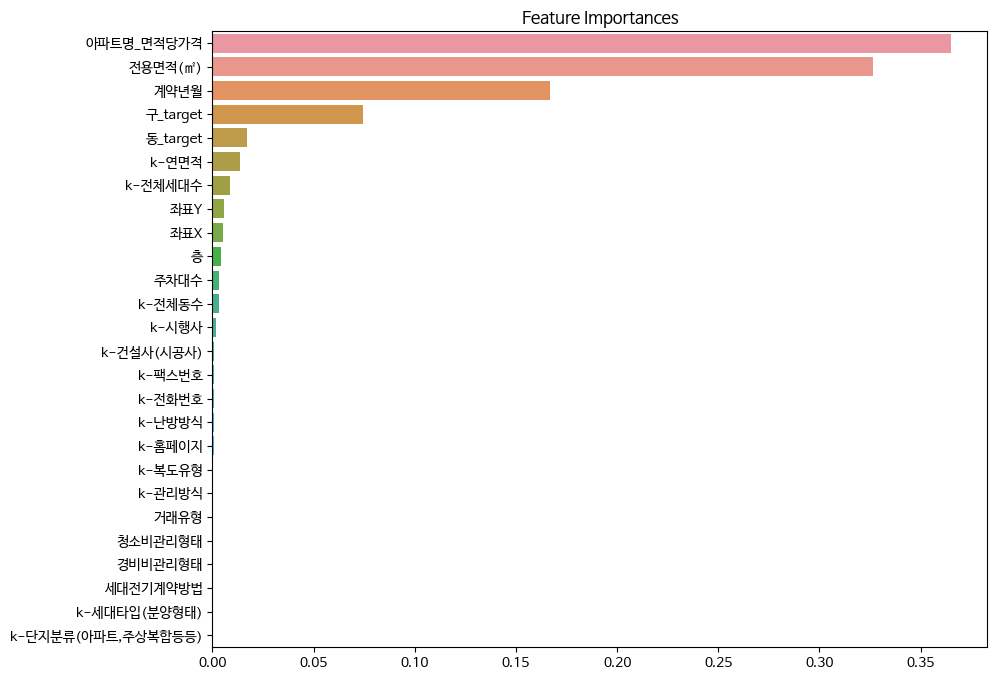

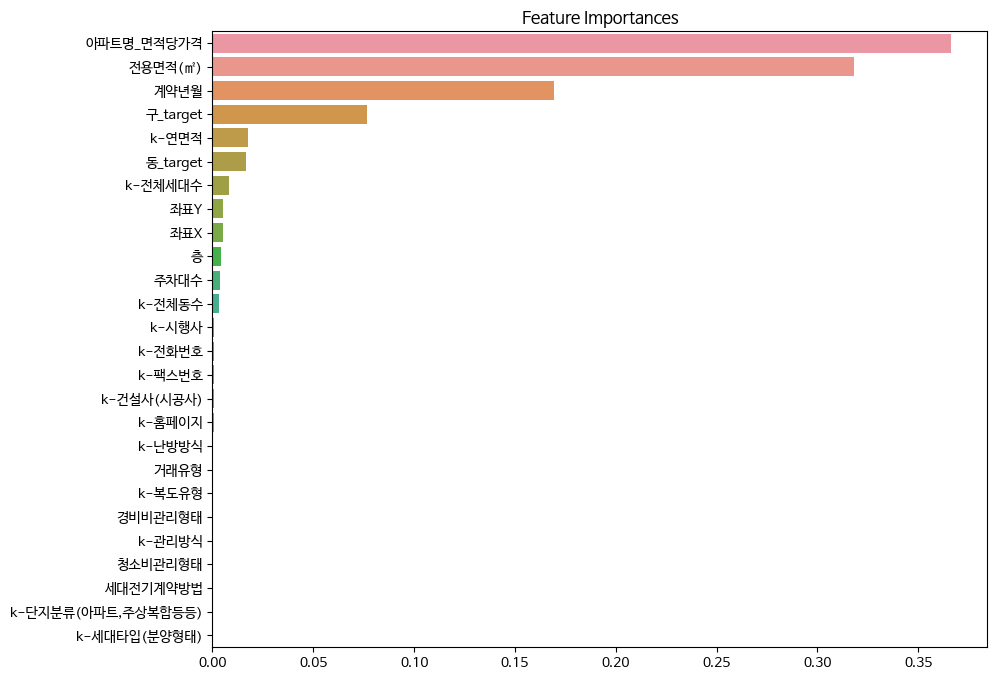

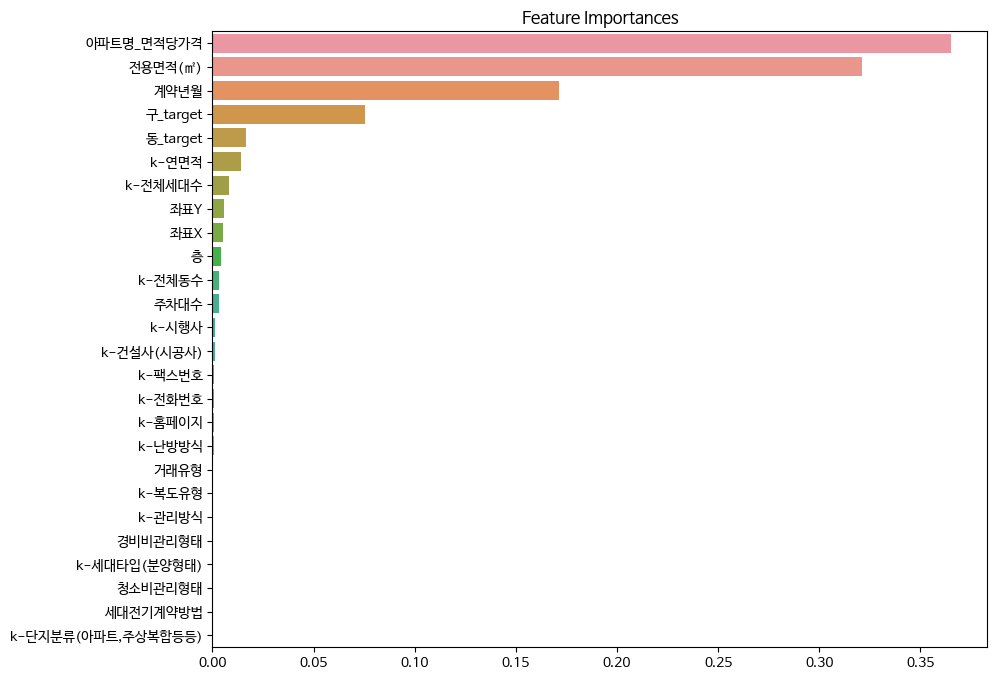

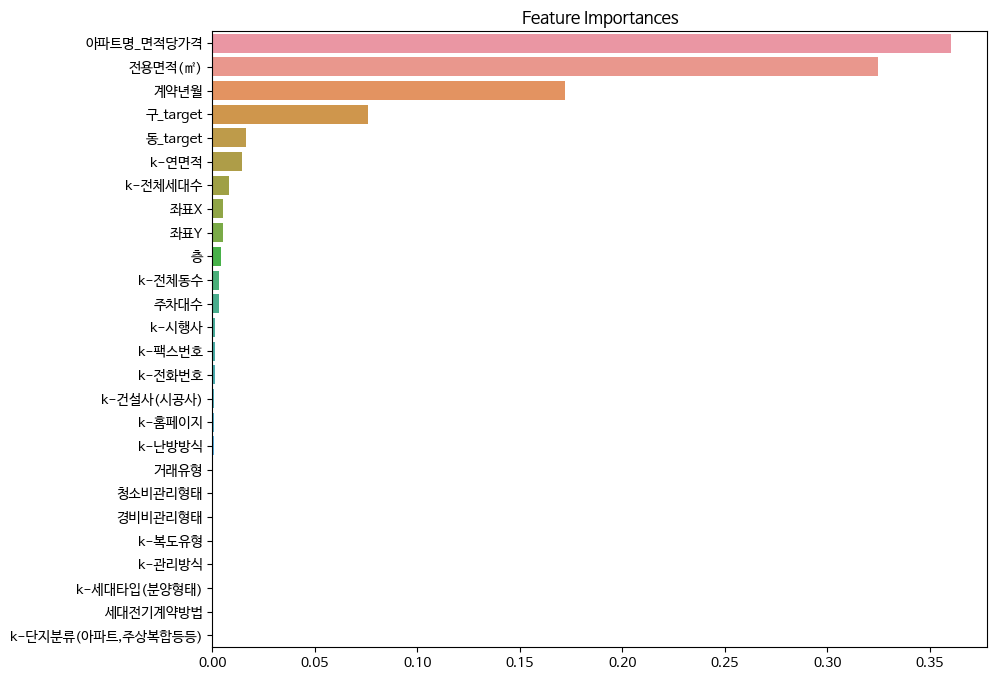

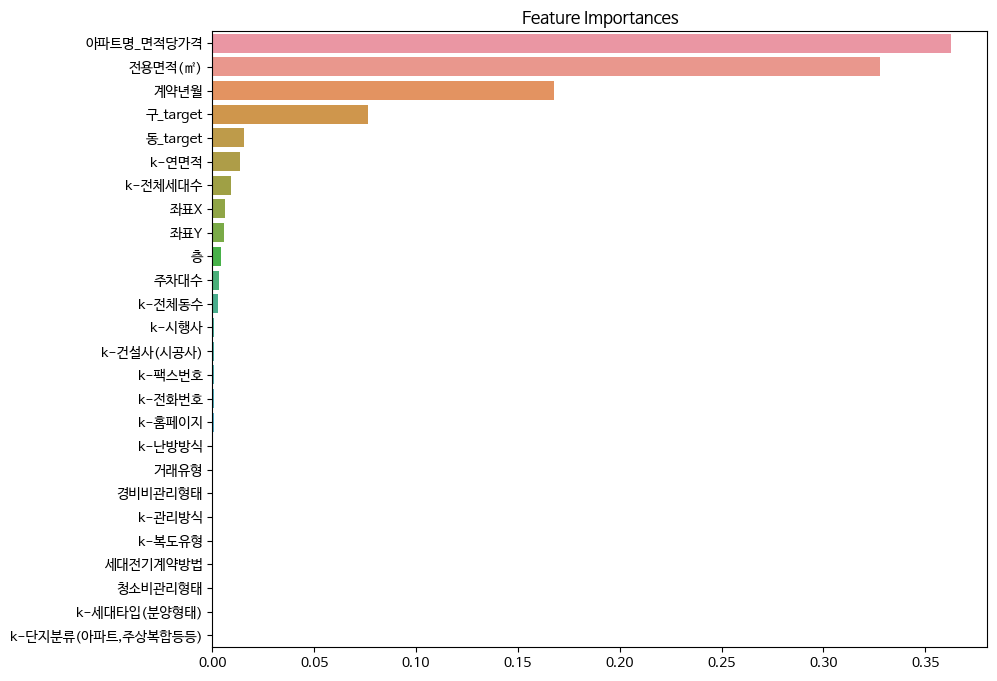

In [85]:
for model in models:
  # 위 feature importance를 시각화해봅니다.
  importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
  importances = importances.sort_values(ascending=False)

  plt.figure(figsize=(10,8))
  plt.title("Feature Importances")
  sns.barplot(x=importances, y=importances.index)
  plt.show()

In [54]:
# model들로 test_set inference
df_train_inference, df_test_inference = target_encoding(df_train, df_test, 'target', '구')
df_train_inference, df_test_inference = dong_target_encoding(df_train_inference, df_test_inference, 'target')
df_train_inference, df_test_inference = apartment_target_encoding(df_train_inference, df_test_inference, 'target')

numeric_features = df_test_inference.select_dtypes(include=[np.number]).columns
categorical_features = df_test_inference.select_dtypes(include=[np.object]).columns

# 범주형 변수에 대한 보간
df_train_inference[categorical_features] = df_train_inference[categorical_features].fillna('NULL')
df_test_inference[categorical_features] = df_test_inference[categorical_features].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
df_train_inference[numeric_features] = df_train_inference[numeric_features].interpolate(method='linear', axis=0)
df_test_inference[numeric_features] = df_test_inference[numeric_features].interpolate(method='linear', axis=0)

# 레이블 인코딩
df_train_inference, df_test_inference, label_encoders = label_encoding(df_train_inference, df_test_inference)


# 1. 각 모델의 예측값을 저장할 리스트
predictions = []

# 2. 각 모델의 예측 수행
for model in models:
    pred = model.predict(df_test_inference)
    predictions.append(pred)

# 3. 예측값들을 numpy 배열로 변환
predictions = np.array(predictions)

# 4. 앙상블 방식 선택
# 4-1. 평균 (가장 일반적인 방식)
ensemble_pred = np.mean(predictions, axis=0)
  
# df 변환
output = pd.DataFrame(ensemble_pred.astype(int), columns=["target"])
output.to_csv('./../../Datas/output.csv', index=False)


100%|██████████| 14/14 [00:06<00:00,  2.08it/s]
